In [1]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import math
import string
import os
import os.path
import heapq
from discreteMarkovChain import markovChain



# Functions

* "compareImg": This function takes a data frame as the input, specifically the one defined above. Then creates a new empty adjacency matrix that will be used for creating the weighted similarity edges for the paintings. The only way the matrix is populated is through looking at the paintings in years following the painting you are currently looking at. This matrix is then returned

* "retrieveMtch": This function takes in two image paths, and then is put through the same detection that was used above. However, instead of graphing the matches, I do a simple count and compare it to the min number of keypoints between the two paintings. This is because more key points cant be matched than already exist. Then the ratio of matches to the min keypoints is returned. This is our creativity score for the features. 



In [101]:
#Imgs

def compareImg(df, k):
    #need to initialize the adjacency matrix for creativity
    #Standard way to get range between 0
    m = np.zeros((len(df), len(df)))
    for p in df.index:
        #print(df.iloc[df.index.get_loc(p) + 1:].index)
        #for each painting after the current painting. They should be sorted by year
        tn = temporalNeighbors(df, df.index.get_loc(p), k)
        for pC in tn:
            if df.loc[p]['year'] < df.iloc[pC]['year']:

                #print(df.loc[p]['Path'], df.loc[pC]['Path'])
                r = retrieveMtch(p, df.iloc[pC].name)
                m[df.index.get_loc(p)][pC] = r
                
    return m

#defined outside, this way it doesn't get recreated everytime               
surf = cv2.xfeatures2d.SURF_create(1000)


                
                
def retrieveMtch(path1, path2):
    img1 = cv2.imread("train_1/" + path1, 0)
    img2 = cv2.imread("train_1/" + path2, 0)
    
    #print(path1, path2)
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)
    
    bf = cv2.BFMatcher() #Trying this out "cv2.NORM_HAMMING, crossCheck=False"
    matches = bf.knnMatch(des1,des2, k=2)
#     bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
#     matches = bf.match(des1,des2)

    mx = min(len(des1), len(des2))
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    # ratio of the total num of matches vs the max number of keypoints that could have been matched. 
    # that max is the min number of keypoints between the two paintings. 
    ratio = len(good)/mx
            
    return ratio
    

* "temporalNeighbors": This function is for finding the k closest paintings to the current index. Taking in a dataframe, an index, and a k value for locating these values. The original idea is to apply this once the balancing function has been applied. 

* "balanceW": This function will take in an input array, in theory the adjacency matrix, and creates a new matrix of the same size. Then a weight, taken by the percentile function from np, is checked against each of the values in the array. If subtracting the value produced a negative weight, the edge is reversed. From i -> j now i <- j. Otherwise it remains 0 or the weight is just the positive version of the original weight minus the balancing value. Returns this new array. 

* "normalizeNP": This function take s in a np array as its input, and then takes the sum of the row. Then divides each cell by that total. If the total is 0, then the cells are given equal weights. This is returned. 

In [63]:
#When using the balancing function I need to change the ij value to ji, and then set ij to 0 and ji to pos(ij)

#will return a list of size k, or max num of neighbors of the indices of the nearest neighbors

#Maybe make this for only neighbors that have a greater year?
def temporalNeighbors(df, i, k):
    curY = df.iloc[i]['year']

    if k > (len(df) - len(df.loc[df['year'] == curY])):
        k = len(df) - len(df.loc[df['year'] == curY]) - 1
                
    ind = list(np.zeros(k))
    n = list(np.full(k, np.inf))
    
    
    for j in range(len(df) - 1):
        tY = df.iloc[j]['year']
        if tY != curY:
            #get the dif of years
            if abs(tY - curY) < max(n):
                idx = n.index(max(n))
                #set the values if this is less than the max number in n
                n[idx] = abs(tY - curY)
                ind[idx] = int(j)
                
#     print(ind)
    
    return ind

# Maybe output two arrays, the ones that stay with the subsequent paintings
# then the other that outputs the prior ones (the ones whoes weights switch between i and j)

def balanceW(inpAr):
    ar = np.zeros((len(inpAr), len(inpAr)))
#     m = np.average(ar) #maybe change this to the percentile function
    m = np.percentile(inpAr, 50)
    for i in range(len(ar)):
        for j in range(len(ar[i])):
            newW = inpAr[i][j] - m
            if inpAr[i][j] == 0:
                pass
            elif newW > 0:
                ar[i][j] = newW
            else:
                # this will swap the direciton of the edges of influence essentially. 
                ar[j][i] = -newW
#                 ar[i][j] = 0
    # return balanced version of the array
    #this way I can have both
    return ar

# this is for normalizing the array for the markovChains
def normalizeNP(inpAr):
    ar = np.zeros((len(inpAr), len(inpAr)))
    print(ar)
    for i in range(len(ar)):
        tot = sum(inpAr[i])
        print(tot)
        if tot > 0.0:
            for j in range(len(ar)):
                ar[i][j] = inpAr[i][j] / tot
        if tot == 0.0:
            for j in range(len(ar)):
                
                ar[i][j] = 1 / len(ar[i])
            
    print(ar)
    return ar

# Data Clean Up

This portion of the code is aimed at slimming the given .csv file into a usable file. When I first import this file it contains over 80,000 rows. Far more than the number of images that I have downloaded. Instead, I will first remove any null values from the .csv file.

In [391]:
paintDF = pd.read_csv('train_info.csv', index_col=0)


In [392]:
paintDF = paintDF.dropna()

paintDF


,artist,title,style,genre,date
filename,,,,,
102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0
53180.jpg,782192dc825c7c1149825adcb7caacbc,Camellia and Bush Warbler,Ukiyo-e,bird-and-flower painting,1844
70944.jpg,afdfc43410410892bc9d1c4d3c3d6220,Forbidden Land,Surrealism,landscape,1937.0
99442.jpg,d09f796f2b0aa11dffc88badd9806119,Storm at sea,Romanticism,marina,1873
82352.jpg,e655bc106f0f640870bc811cd29e6d8d,The Garden of Earthly Delights,Northern Renaissance,religious painting,1515
27254.jpg,782192dc825c7c1149825adcb7caacbc,"Moon, Swallows and Peach Blossoms",Ukiyo-e,bird-and-flower painting,1850
47145.jpg,782192dc825c7c1149825adcb7caacbc,Sparrows and Camellias in the Snow,Ukiyo-e,bird-and-flower painting,1838


Next, this commented out code normalizes the date column in the dataframe. This is to ensure that ever date is a 3-4 digit number that can be compared to one another. That is the entire function of the code. It is commented out because it takes so long to run. 

Finally the years are added into the dataframe, and then the old date column is dropped. 

In [393]:
# Need to normalize the years in the table
# dates = {}
# for i in paintDF.index:
#     d = paintDF.loc[i]['date']
#     if d[0] in string.ascii_letters:
#         dates[i] = (int(d[-4:]))

#     elif d[-2] == '.':
#         dates[i] = (int(d[:-2]))
#     else:
#         dates[i] = (int(d))
        
#     years = pd.DataFrame.from_dict(dates, 'index')
    

In [394]:
years = years.rename(columns = {'date': 'year'})
#going to have to index these...
# doesn't seem to work properly
paintDF = pd.concat([paintDF, years], axis=1)


In [395]:
paintDF = paintDF.drop(['date'], axis=1)


Next this code just drops each row that isn't a picture in the directory of images I have. This leaves me with around 8000 images in the dataframe. 

In [396]:
# Remove the pictures not in the directory
clean_paintDF = paintDF

for i in paintDF.index:
    file = "train_1/" + i
    if not os.path.exists(file):
        clean_paintDF = clean_paintDF.drop(i)
    else:
        print("exists: " + i)
        

exists: 102257.jpg
exists: 16876.jpg
exists: 1164.jpg
exists: 19385.jpg
exists: 17354.jpg
exists: 13689.jpg
exists: 19834.jpg
exists: 15569.jpg
exists: 1127.jpg
exists: 100478.jpg
exists: 100829.jpg
exists: 16019.jpg
exists: 11057.jpg
exists: 102176.jpg
exists: 10805.jpg
exists: 101495.jpg
exists: 11837.jpg
exists: 100182.jpg
exists: 18100.jpg
exists: 1211.jpg
exists: 12262.jpg
exists: 17903.jpg
exists: 101078.jpg
exists: 102671.jpg
exists: 17146.jpg
exists: 12455.jpg
exists: 1089.jpg
exists: 12836.jpg
exists: 19281.jpg
exists: 17862.jpg
exists: 19525.jpg
exists: 1049.jpg
exists: 18147.jpg
exists: 102442.jpg
exists: 16347.jpg
exists: 186.jpg
exists: 11455.jpg
exists: 102837.jpg
exists: 11908.jpg
exists: 13273.jpg
exists: 102940.jpg
exists: 18398.jpg
exists: 13889.jpg
exists: 1658.jpg
exists: 100830.jpg
exists: 19464.jpg
exists: 13949.jpg
exists: 10590.jpg
exists: 11091.jpg
exists: 19749.jpg
exists: 102149.jpg
exists: 15571.jpg
exists: 1534.jpg
exists: 16621.jpg
exists: 100300.jpg
exist

exists: 14895.jpg
exists: 11321.jpg
exists: 14775.jpg
exists: 1974.jpg
exists: 16473.jpg
exists: 10661.jpg
exists: 17696.jpg
exists: 1903.jpg
exists: 100084.jpg
exists: 103094.jpg
exists: 100280.jpg
exists: 12403.jpg
exists: 10958.jpg
exists: 18372.jpg
exists: 102431.jpg
exists: 11823.jpg
exists: 1800.jpg
exists: 14873.jpg
exists: 13458.jpg
exists: 103118.jpg
exists: 102588.jpg
exists: 102651.jpg
exists: 11048.jpg
exists: 11030.jpg
exists: 11406.jpg
exists: 16259.jpg
exists: 100412.jpg
exists: 17780.jpg
exists: 13155.jpg
exists: 17437.jpg
exists: 18532.jpg
exists: 14576.jpg
exists: 10711.jpg
exists: 17946.jpg
exists: 102264.jpg
exists: 13548.jpg
exists: 12456.jpg
exists: 1855.jpg
exists: 14961.jpg
exists: 14902.jpg
exists: 14760.jpg
exists: 14046.jpg
exists: 10717.jpg
exists: 14092.jpg
exists: 18498.jpg
exists: 14186.jpg
exists: 12419.jpg
exists: 100398.jpg
exists: 102899.jpg
exists: 13538.jpg
exists: 14634.jpg
exists: 17515.jpg
exists: 11318.jpg
exists: 13223.jpg
exists: 15743.jpg
exi

exists: 17395.jpg
exists: 17511.jpg
exists: 1286.jpg
exists: 102985.jpg
exists: 15986.jpg
exists: 11857.jpg
exists: 10079.jpg
exists: 10879.jpg
exists: 18458.jpg
exists: 100113.jpg
exists: 12330.jpg
exists: 14396.jpg
exists: 19166.jpg
exists: 16224.jpg
exists: 15938.jpg
exists: 102237.jpg
exists: 100819.jpg
exists: 100286.jpg
exists: 12845.jpg
exists: 1674.jpg
exists: 14696.jpg
exists: 1782.jpg
exists: 11359.jpg
exists: 14020.jpg
exists: 16630.jpg
exists: 16733.jpg
exists: 15019.jpg
exists: 14528.jpg
exists: 10944.jpg
exists: 1477.jpg
exists: 12390.jpg
exists: 15684.jpg
exists: 13350.jpg
exists: 16311.jpg
exists: 12344.jpg
exists: 14253.jpg
exists: 11532.jpg
exists: 19219.jpg
exists: 15312.jpg
exists: 18047.jpg
exists: 10078.jpg
exists: 19106.jpg
exists: 10256.jpg
exists: 16232.jpg
exists: 12794.jpg
exists: 102716.jpg
exists: 103000.jpg
exists: 101524.jpg
exists: 10533.jpg
exists: 17748.jpg
exists: 12199.jpg
exists: 12537.jpg
exists: 100832.jpg
exists: 12688.jpg
exists: 17286.jpg
exist

exists: 12335.jpg
exists: 18277.jpg
exists: 15801.jpg
exists: 101746.jpg
exists: 102679.jpg
exists: 12868.jpg
exists: 16314.jpg
exists: 12520.jpg
exists: 15442.jpg
exists: 11952.jpg
exists: 102965.jpg
exists: 18768.jpg
exists: 10315.jpg
exists: 102466.jpg
exists: 19556.jpg
exists: 101389.jpg
exists: 19754.jpg
exists: 13504.jpg
exists: 10206.jpg
exists: 102523.jpg
exists: 12604.jpg
exists: 101380.jpg
exists: 13693.jpg
exists: 18572.jpg
exists: 15586.jpg
exists: 103199.jpg
exists: 101751.jpg
exists: 16709.jpg
exists: 15711.jpg
exists: 19415.jpg
exists: 102011.jpg
exists: 10204.jpg
exists: 15479.jpg
exists: 101762.jpg
exists: 103074.jpg
exists: 1799.jpg
exists: 15981.jpg
exists: 19109.jpg
exists: 14661.jpg
exists: 100095.jpg
exists: 19755.jpg
exists: 16058.jpg
exists: 13704.jpg
exists: 103071.jpg
exists: 1668.jpg
exists: 11323.jpg
exists: 13393.jpg
exists: 13876.jpg
exists: 11811.jpg
exists: 102736.jpg
exists: 18179.jpg
exists: 11603.jpg
exists: 102695.jpg
exists: 19362.jpg
exists: 13426.

exists: 17636.jpg
exists: 16937.jpg
exists: 17086.jpg
exists: 17563.jpg
exists: 11845.jpg
exists: 13720.jpg
exists: 102253.jpg
exists: 14332.jpg
exists: 15066.jpg
exists: 10219.jpg
exists: 13152.jpg
exists: 10896.jpg
exists: 10782.jpg
exists: 18370.jpg
exists: 19591.jpg
exists: 15800.jpg
exists: 102016.jpg
exists: 14559.jpg
exists: 19192.jpg
exists: 102331.jpg
exists: 13630.jpg
exists: 1091.jpg
exists: 17797.jpg
exists: 103216.jpg
exists: 12948.jpg
exists: 11289.jpg
exists: 14216.jpg
exists: 103009.jpg
exists: 13159.jpg
exists: 102201.jpg
exists: 1828.jpg
exists: 102486.jpg
exists: 102590.jpg
exists: 11247.jpg
exists: 18131.jpg
exists: 101521.jpg
exists: 1222.jpg
exists: 10538.jpg
exists: 1485.jpg
exists: 11943.jpg
exists: 18635.jpg
exists: 13922.jpg
exists: 15510.jpg
exists: 16269.jpg
exists: 14155.jpg
exists: 1025.jpg
exists: 1133.jpg
exists: 15327.jpg
exists: 16609.jpg
exists: 14355.jpg
exists: 17853.jpg
exists: 102606.jpg
exists: 15044.jpg
exists: 15102.jpg
exists: 14681.jpg
exists

exists: 102306.jpg
exists: 11571.jpg
exists: 102441.jpg
exists: 16981.jpg
exists: 101354.jpg
exists: 17294.jpg
exists: 10518.jpg
exists: 101546.jpg
exists: 16185.jpg
exists: 13980.jpg
exists: 11775.jpg
exists: 113.jpg
exists: 18027.jpg
exists: 19493.jpg
exists: 11764.jpg
exists: 12094.jpg
exists: 102839.jpg
exists: 15836.jpg
exists: 14778.jpg
exists: 100348.jpg
exists: 11920.jpg
exists: 14214.jpg
exists: 101130.jpg
exists: 101646.jpg
exists: 1691.jpg
exists: 102364.jpg
exists: 11043.jpg
exists: 12060.jpg
exists: 15979.jpg
exists: 10406.jpg
exists: 1514.jpg
exists: 19801.jpg
exists: 12611.jpg
exists: 13191.jpg
exists: 19261.jpg
exists: 17932.jpg
exists: 11204.jpg
exists: 12040.jpg
exists: 101939.jpg
exists: 15805.jpg
exists: 13344.jpg
exists: 15002.jpg
exists: 13270.jpg
exists: 11001.jpg
exists: 12967.jpg
exists: 102859.jpg
exists: 12994.jpg
exists: 13622.jpg
exists: 16836.jpg
exists: 100995.jpg
exists: 16558.jpg
exists: 18909.jpg
exists: 11199.jpg
exists: 17546.jpg
exists: 10363.jpg
ex

exists: 14551.jpg
exists: 12157.jpg
exists: 12279.jpg
exists: 102097.jpg
exists: 12102.jpg
exists: 17458.jpg
exists: 10013.jpg
exists: 13932.jpg
exists: 124.jpg
exists: 11453.jpg
exists: 19808.jpg
exists: 16957.jpg
exists: 19991.jpg
exists: 10848.jpg
exists: 18833.jpg
exists: 17672.jpg
exists: 102297.jpg
exists: 12749.jpg
exists: 100249.jpg
exists: 102462.jpg
exists: 13808.jpg
exists: 12307.jpg
exists: 19868.jpg
exists: 11103.jpg
exists: 1304.jpg
exists: 1317.jpg
exists: 103072.jpg
exists: 17327.jpg
exists: 13050.jpg
exists: 19679.jpg
exists: 18636.jpg
exists: 100591.jpg
exists: 17529.jpg
exists: 15091.jpg
exists: 11054.jpg
exists: 16972.jpg
exists: 19054.jpg
exists: 1990.jpg
exists: 16800.jpg
exists: 11791.jpg
exists: 101480.jpg
exists: 100928.jpg
exists: 100747.jpg
exists: 1775.jpg
exists: 17551.jpg
exists: 100595.jpg
exists: 11962.jpg
exists: 11015.jpg
exists: 102046.jpg
exists: 14771.jpg
exists: 14456.jpg
exists: 15834.jpg
exists: 11688.jpg
exists: 100942.jpg
exists: 11374.jpg
exis

exists: 16.jpg
exists: 101931.jpg
exists: 12350.jpg
exists: 12587.jpg
exists: 18311.jpg
exists: 12642.jpg
exists: 101499.jpg
exists: 19422.jpg
exists: 10897.jpg
exists: 1749.jpg
exists: 102310.jpg
exists: 10565.jpg
exists: 1308.jpg
exists: 12501.jpg
exists: 17266.jpg
exists: 17733.jpg
exists: 18615.jpg
exists: 102485.jpg
exists: 13829.jpg
exists: 18596.jpg
exists: 102390.jpg
exists: 102298.jpg
exists: 1642.jpg
exists: 100121.jpg
exists: 14053.jpg
exists: 13018.jpg
exists: 15887.jpg
exists: 19710.jpg
exists: 12410.jpg
exists: 13817.jpg
exists: 15573.jpg
exists: 102329.jpg
exists: 102781.jpg
exists: 100230.jpg
exists: 13756.jpg
exists: 101950.jpg
exists: 13824.jpg
exists: 102870.jpg
exists: 17392.jpg
exists: 100847.jpg
exists: 18026.jpg
exists: 18462.jpg
exists: 13389.jpg
exists: 102949.jpg
exists: 13166.jpg
exists: 18206.jpg
exists: 12942.jpg
exists: 13398.jpg
exists: 101861.jpg
exists: 11230.jpg
exists: 100011.jpg
exists: 13321.jpg
exists: 16673.jpg
exists: 102914.jpg
exists: 101627.jp

exists: 14468.jpg
exists: 10646.jpg
exists: 100250.jpg
exists: 15139.jpg
exists: 18929.jpg
exists: 15158.jpg
exists: 10734.jpg
exists: 102811.jpg
exists: 17131.jpg
exists: 102938.jpg
exists: 18665.jpg
exists: 18534.jpg
exists: 18687.jpg
exists: 100411.jpg
exists: 17297.jpg
exists: 17960.jpg
exists: 1114.jpg
exists: 13642.jpg
exists: 100920.jpg
exists: 11632.jpg
exists: 19537.jpg
exists: 12725.jpg
exists: 10503.jpg
exists: 18845.jpg
exists: 15170.jpg
exists: 12925.jpg
exists: 1476.jpg
exists: 100879.jpg
exists: 11806.jpg
exists: 10250.jpg
exists: 16855.jpg
exists: 18317.jpg
exists: 101894.jpg
exists: 17114.jpg
exists: 16415.jpg
exists: 13512.jpg
exists: 17906.jpg
exists: 17279.jpg
exists: 101140.jpg
exists: 10168.jpg
exists: 17926.jpg
exists: 1276.jpg
exists: 1795.jpg
exists: 100654.jpg
exists: 11133.jpg
exists: 101227.jpg
exists: 12705.jpg
exists: 10164.jpg
exists: 12679.jpg
exists: 18008.jpg
exists: 19147.jpg
exists: 102320.jpg
exists: 101359.jpg
exists: 14480.jpg
exists: 10647.jpg
ex

exists: 18809.jpg
exists: 12500.jpg
exists: 14878.jpg
exists: 16301.jpg
exists: 11771.jpg
exists: 102228.jpg
exists: 102821.jpg
exists: 101585.jpg
exists: 14349.jpg
exists: 15445.jpg
exists: 18320.jpg
exists: 12608.jpg
exists: 12556.jpg
exists: 13431.jpg
exists: 102259.jpg
exists: 11798.jpg
exists: 14098.jpg
exists: 19811.jpg
exists: 16197.jpg
exists: 101685.jpg
exists: 14350.jpg
exists: 102355.jpg
exists: 11486.jpg
exists: 19269.jpg
exists: 12503.jpg
exists: 17786.jpg
exists: 15028.jpg
exists: 15857.jpg
exists: 18352.jpg
exists: 16551.jpg
exists: 101242.jpg
exists: 13069.jpg
exists: 1483.jpg
exists: 10354.jpg
exists: 11833.jpg
exists: 103248.jpg
exists: 13221.jpg
exists: 14479.jpg
exists: 13471.jpg
exists: 16231.jpg
exists: 14910.jpg
exists: 12430.jpg
exists: 100945.jpg
exists: 101699.jpg
exists: 14953.jpg
exists: 101312.jpg
exists: 102476.jpg
exists: 14059.jpg
exists: 101704.jpg
exists: 12362.jpg
exists: 12433.jpg
exists: 18210.jpg
exists: 10572.jpg
exists: 14727.jpg
exists: 13464.jp

exists: 12021.jpg
exists: 19708.jpg
exists: 15976.jpg
exists: 19921.jpg
exists: 17202.jpg
exists: 13241.jpg
exists: 13717.jpg
exists: 13950.jpg
exists: 101696.jpg
exists: 13062.jpg
exists: 12133.jpg
exists: 101144.jpg
exists: 100611.jpg
exists: 100226.jpg
exists: 102740.jpg
exists: 101023.jpg
exists: 101293.jpg
exists: 13271.jpg
exists: 16194.jpg
exists: 12675.jpg
exists: 11073.jpg
exists: 12843.jpg
exists: 14959.jpg
exists: 12740.jpg
exists: 102429.jpg
exists: 19966.jpg
exists: 101915.jpg
exists: 18729.jpg
exists: 19178.jpg
exists: 11630.jpg
exists: 12096.jpg
exists: 18937.jpg
exists: 17591.jpg
exists: 13438.jpg
exists: 16608.jpg
exists: 13535.jpg
exists: 12170.jpg
exists: 17036.jpg
exists: 11053.jpg
exists: 14490.jpg
exists: 101208.jpg
exists: 12956.jpg
exists: 17518.jpg
exists: 14829.jpg
exists: 102408.jpg
exists: 12494.jpg
exists: 1410.jpg
exists: 12605.jpg
exists: 17445.jpg
exists: 16897.jpg
exists: 102911.jpg
exists: 16817.jpg
exists: 15883.jpg
exists: 101702.jpg
exists: 10138.jp

exists: 12353.jpg
exists: 1348.jpg
exists: 15199.jpg
exists: 100393.jpg
exists: 102664.jpg
exists: 17031.jpg
exists: 19689.jpg
exists: 19580.jpg
exists: 101838.jpg
exists: 13397.jpg
exists: 13086.jpg
exists: 102639.jpg
exists: 100346.jpg
exists: 18070.jpg
exists: 18030.jpg
exists: 14805.jpg
exists: 13770.jpg
exists: 120.jpg
exists: 13462.jpg
exists: 1189.jpg
exists: 13890.jpg
exists: 15956.jpg
exists: 17922.jpg
exists: 100605.jpg
exists: 12345.jpg
exists: 14529.jpg
exists: 11528.jpg
exists: 13310.jpg
exists: 13750.jpg
exists: 16174.jpg
exists: 102422.jpg
exists: 11822.jpg
exists: 13220.jpg
exists: 15256.jpg
exists: 16694.jpg
exists: 13791.jpg
exists: 1912.jpg
exists: 14103.jpg
exists: 17207.jpg
exists: 17120.jpg
exists: 14461.jpg
exists: 102893.jpg
exists: 16423.jpg
exists: 1138.jpg
exists: 18737.jpg
exists: 19971.jpg
exists: 15246.jpg
exists: 10476.jpg
exists: 100079.jpg
exists: 17093.jpg
exists: 17428.jpg
exists: 1415.jpg
exists: 102723.jpg
exists: 16677.jpg
exists: 19448.jpg
exists:

exists: 19197.jpg
exists: 14783.jpg
exists: 1346.jpg
exists: 19027.jpg
exists: 16274.jpg
exists: 18177.jpg
exists: 13138.jpg
exists: 13293.jpg
exists: 13114.jpg
exists: 13637.jpg
exists: 18540.jpg
exists: 19077.jpg
exists: 199.jpg
exists: 14740.jpg
exists: 1607.jpg
exists: 19622.jpg
exists: 13574.jpg
exists: 18388.jpg
exists: 12270.jpg
exists: 13346.jpg
exists: 11625.jpg
exists: 12434.jpg
exists: 16220.jpg
exists: 11235.jpg
exists: 12617.jpg
exists: 19317.jpg
exists: 16602.jpg
exists: 17552.jpg
exists: 14831.jpg
exists: 17134.jpg
exists: 1783.jpg
exists: 13941.jpg
exists: 14357.jpg
exists: 12334.jpg
exists: 11276.jpg
exists: 18203.jpg
exists: 10582.jpg
exists: 16253.jpg
exists: 13197.jpg
exists: 19330.jpg
exists: 14751.jpg
exists: 10018.jpg
exists: 12167.jpg
exists: 19468.jpg
exists: 100020.jpg
exists: 17782.jpg
exists: 101493.jpg
exists: 1750.jpg
exists: 102360.jpg
exists: 13968.jpg
exists: 100716.jpg
exists: 19886.jpg
exists: 10691.jpg
exists: 14945.jpg
exists: 16324.jpg
exists: 1781

exists: 101251.jpg
exists: 100950.jpg
exists: 11075.jpg
exists: 15912.jpg
exists: 15424.jpg
exists: 14037.jpg
exists: 19096.jpg
exists: 103156.jpg
exists: 10300.jpg
exists: 102117.jpg
exists: 15116.jpg
exists: 101711.jpg
exists: 100350.jpg
exists: 101434.jpg
exists: 13767.jpg
exists: 16140.jpg
exists: 102785.jpg
exists: 19819.jpg
exists: 10258.jpg
exists: 103109.jpg
exists: 17291.jpg
exists: 16117.jpg
exists: 13542.jpg
exists: 14610.jpg
exists: 15539.jpg
exists: 19396.jpg
exists: 100145.jpg
exists: 19739.jpg
exists: 1616.jpg
exists: 11933.jpg
exists: 102332.jpg
exists: 14202.jpg
exists: 16307.jpg
exists: 10589.jpg
exists: 11981.jpg
exists: 102810.jpg
exists: 16380.jpg
exists: 13903.jpg
exists: 19165.jpg
exists: 12163.jpg
exists: 12082.jpg
exists: 12954.jpg
exists: 14988.jpg
exists: 101628.jpg
exists: 19337.jpg
exists: 19759.jpg
exists: 19278.jpg
exists: 1061.jpg
exists: 19046.jpg
exists: 100914.jpg
exists: 15950.jpg
exists: 100923.jpg
exists: 10927.jpg
exists: 1720.jpg
exists: 15232.jp

exists: 103234.jpg
exists: 1212.jpg
exists: 10037.jpg
exists: 13572.jpg
exists: 17310.jpg
exists: 11705.jpg
exists: 11740.jpg
exists: 19338.jpg
exists: 100498.jpg
exists: 12916.jpg
exists: 102804.jpg
exists: 16167.jpg
exists: 100724.jpg
exists: 15271.jpg
exists: 18593.jpg
exists: 19112.jpg
exists: 16797.jpg
exists: 19618.jpg
exists: 13158.jpg
exists: 1874.jpg
exists: 16141.jpg
exists: 16358.jpg
exists: 11974.jpg
exists: 1550.jpg
exists: 12997.jpg
exists: 15165.jpg
exists: 1731.jpg
exists: 103022.jpg
exists: 103040.jpg
exists: 17767.jpg
exists: 17975.jpg
exists: 14708.jpg
exists: 13645.jpg
exists: 103147.jpg
exists: 11362.jpg
exists: 14405.jpg
exists: 15637.jpg
exists: 13790.jpg
exists: 13774.jpg
exists: 17169.jpg
exists: 19119.jpg
exists: 100431.jpg
exists: 101693.jpg
exists: 15771.jpg
exists: 15391.jpg
exists: 17969.jpg
exists: 10767.jpg
exists: 10930.jpg
exists: 15179.jpg
exists: 1714.jpg
exists: 13425.jpg
exists: 11515.jpg
exists: 19466.jpg
exists: 100229.jpg
exists: 1173.jpg
exists

exists: 18704.jpg
exists: 16545.jpg
exists: 100247.jpg
exists: 14153.jpg
exists: 17421.jpg
exists: 1581.jpg
exists: 122.jpg
exists: 100320.jpg
exists: 100075.jpg
exists: 11529.jpg
exists: 16726.jpg
exists: 12293.jpg
exists: 19783.jpg
exists: 17487.jpg
exists: 11191.jpg
exists: 14275.jpg
exists: 17990.jpg
exists: 14035.jpg
exists: 101821.jpg
exists: 14079.jpg
exists: 1739.jpg
exists: 100433.jpg
exists: 103171.jpg
exists: 105.jpg
exists: 19393.jpg
exists: 17509.jpg
exists: 15401.jpg
exists: 18689.jpg
exists: 13483.jpg
exists: 14353.jpg
exists: 11734.jpg
exists: 102509.jpg
exists: 10350.jpg
exists: 18619.jpg
exists: 13842.jpg
exists: 17255.jpg
exists: 11310.jpg
exists: 10080.jpg
exists: 17356.jpg
exists: 15202.jpg
exists: 1491.jpg
exists: 101435.jpg
exists: 16164.jpg
exists: 17729.jpg
exists: 1960.jpg
exists: 1956.jpg
exists: 10128.jpg
exists: 100846.jpg
exists: 102989.jpg
exists: 14954.jpg
exists: 10254.jpg
exists: 14852.jpg
exists: 100177.jpg
exists: 19613.jpg
exists: 11634.jpg
exists: 

exists: 10904.jpg
exists: 13726.jpg
exists: 1207.jpg
exists: 1377.jpg
exists: 16687.jpg
exists: 12513.jpg
exists: 101542.jpg
exists: 15636.jpg
exists: 19765.jpg
exists: 17329.jpg
exists: 101994.jpg
exists: 19965.jpg
exists: 11007.jpg
exists: 1333.jpg
exists: 19977.jpg
exists: 1568.jpg
exists: 101080.jpg
exists: 11340.jpg
exists: 16664.jpg
exists: 10007.jpg
exists: 100131.jpg
exists: 101423.jpg
exists: 17206.jpg
exists: 16755.jpg
exists: 17059.jpg
exists: 102847.jpg
exists: 100246.jpg
exists: 17117.jpg
exists: 100873.jpg
exists: 17308.jpg
exists: 17256.jpg
exists: 18607.jpg
exists: 19084.jpg
exists: 15422.jpg
exists: 19734.jpg
exists: 16254.jpg
exists: 12542.jpg
exists: 13460.jpg
exists: 18984.jpg
exists: 11383.jpg
exists: 12322.jpg
exists: 11186.jpg
exists: 12466.jpg
exists: 101803.jpg
exists: 100047.jpg
exists: 16156.jpg
exists: 101429.jpg
exists: 100881.jpg
exists: 13698.jpg
exists: 101647.jpg
exists: 18748.jpg
exists: 15522.jpg
exists: 16106.jpg
exists: 14083.jpg
exists: 12041.jpg
e

exists: 16898.jpg
exists: 16614.jpg
exists: 102398.jpg
exists: 15111.jpg
exists: 101730.jpg
exists: 16964.jpg
exists: 103173.jpg
exists: 13947.jpg
exists: 19061.jpg
exists: 11353.jpg
exists: 10859.jpg
exists: 11038.jpg
exists: 10432.jpg
exists: 101013.jpg
exists: 102479.jpg
exists: 102834.jpg
exists: 17597.jpg
exists: 13971.jpg
exists: 102233.jpg
exists: 19417.jpg
exists: 18.jpg
exists: 102879.jpg
exists: 18469.jpg
exists: 14507.jpg
exists: 14753.jpg
exists: 10886.jpg
exists: 19379.jpg
exists: 18522.jpg
exists: 12139.jpg
exists: 11862.jpg
exists: 18387.jpg
exists: 11196.jpg
exists: 17399.jpg
exists: 10458.jpg
exists: 1270.jpg
exists: 100251.jpg
exists: 17111.jpg
exists: 100101.jpg
exists: 17507.jpg
exists: 13519.jpg
exists: 10065.jpg
exists: 15788.jpg
exists: 13688.jpg
exists: 11246.jpg
exists: 12824.jpg
exists: 11684.jpg
exists: 13951.jpg
exists: 18199.jpg
exists: 100875.jpg
exists: 12027.jpg
exists: 12918.jpg
exists: 1862.jpg
exists: 102500.jpg
exists: 100119.jpg
exists: 15959.jpg
ex

In [397]:
print(len(clean_paintDF))
#verifying the number of files is correct
li = os.listdir("train_1") # dir is your directory path
print (len(li))

#there appears to be a discrepancy of a few thousand. That is ok, and will move on with the DF
#   as it has less files, look up will be the same

8110
11025


In [398]:
clean_paintDF.to_csv('clean_paint.csv', encoding='utf-8') #save the CSV for later

# Analysis

First I read in the csv file that was saved above (for easy reuse). And then I filter out all paintings that aren't in the 'symbolic painting' genre. This leaves me with 182 paintings. And those are the paintings that my analysis will be done with. 

In [3]:
cpDF = pd.read_csv('clean_paint.csv', index_col=0)
cpDF = cpDF.sort_values(by=['year'])


In [4]:
symb_paintDF = cpDF[cpDF['genre'] == 'symbolic painting']


In [5]:
symb_paintDF


,artist,title,style,genre,year
filename,,,,,
16705.jpg,db1318d32df7428076e03513ebf762bb,Photograph of Guardian Spirit of the Waters,Symbolism,symbolic painting,1878
13066.jpg,db1318d32df7428076e03513ebf762bb,In the balance,Symbolism,symbolic painting,1880
13515.jpg,5a6cecdea04a1e811b6c5ce9257673f8,The Precious Ridiculous,Romanticism,symbolic painting,1883
1861.jpg,db1318d32df7428076e03513ebf762bb,Death: My irony surpasses all others!,Symbolism,symbolic painting,1889
12111.jpg,74a1dad53214d04514269a188f16683a,Night,Art Nouveau (Modern),symbolic painting,1890
101208.jpg,31824744c8ae0c7953098fdab60c7ebf,Skeletons Fighting over a Hanged Man,Expressionism,symbolic painting,1891
15289.jpg,db1318d32df7428076e03513ebf762bb,The Smiling Spider,Symbolism,symbolic painting,1891
16661.jpg,db1318d32df7428076e03513ebf762bb,Sita,Symbolism,symbolic painting,1893
14199.jpg,b1060c5ec0ca23662c00c6a7aebfba59,Melancholia,Symbolism,symbolic painting,1894


Implementing the functions from above, getting the new arrays

In [102]:
imgCompAr = compareImg(symb_paintDF, 10)



In [103]:
imgBalAr = balanceW(imgCompAr)


In [104]:
imgNormAr = normalizeNP(imgBalAr)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.6152380828179295
0.19744388064716942
1.4186448476435958
0.1616969839662752
1.707591986757941
0.19808706098370965
0.35101843896353785
0.1383219954648526
0.2310831773232634
0.08125819134993448
0.12563170495061005
0.06898714224751737
0.1984984984984985
0.13483926285534864
0.46933723534202126
0.4116551125414152
2.558116118273535
0.11943814043050684
0.06870229007633588
0.39276535358230497
4.746459932583433
7.84280797087714
2.229289431949909
1.9741062311369428
3.062307535628724
0.7777020388111029
5.200491536862216
1.0
7.533567198631503
0.2
20.833333333333332
0.1
0.17150417101121865
0.17636013224248517
0.22918739635157548
0.4204328251790844
0.1809228127580575
0.06993006993006994
0.05185185185185185
0.054819774477758806
0.017894736842105262
0.04473684210526316
0.012113055181695828
0.12642137408355278
0.04004290805910239
0.0829945248549899

In [105]:
mc = markovChain(imgNormAr)
mc.computePi('linear')
print(mc.pi)


[0.00055914 0.0006095  0.00059005 0.00072568 0.00061777 0.00077742
 0.00076019 0.00230737 0.00098395 0.00161076 0.0012116  0.00179551
 0.00298237 0.00169166 0.00343397 0.00278224 0.00133379 0.00346307
 0.0066105  0.00208267 0.00343728 0.00185982 0.00243749 0.00234308
 0.00323801 0.00122196 0.00055914 0.00055914 0.00055914 0.00491949
 0.00073373 0.0169388  0.00083911 0.011955   0.00656023 0.00064919
 0.00068466 0.0030214  0.01035742 0.00236465 0.00602327 0.00422865
 0.01379112 0.02460218 0.01262235 0.0108448  0.00281246 0.01675951
 0.01063837 0.01207858 0.00723513 0.01100773 0.00270417 0.00930215
 0.00482548 0.00164445 0.01587811 0.00516146 0.00842574 0.00363484
 0.0035036  0.02674972 0.00263225 0.00716367 0.00330224 0.0043036
 0.00291897 0.00714807 0.0059285  0.00404552 0.0048884  0.00203128
 0.00540546 0.01500742 0.01812381 0.00395799 0.00055914 0.04361296
 0.00055914 0.00459907 0.00099507 0.0014487  0.0014882  0.04107139
 0.00073463 0.00250096 0.00252604 0.00096118 0.01911498 0.00467

In [106]:
symb_paintDF["Creativity Score"] = np.asarray(mc.pi)
symb_paintDF


/Users/reedmershon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,artist,title,style,genre,year,Creativity Score
filename,,,,,,
16705.jpg,db1318d32df7428076e03513ebf762bb,Photograph of Guardian Spirit of the Waters,Symbolism,symbolic painting,1878,0.000559
13066.jpg,db1318d32df7428076e03513ebf762bb,In the balance,Symbolism,symbolic painting,1880,0.000609
13515.jpg,5a6cecdea04a1e811b6c5ce9257673f8,The Precious Ridiculous,Romanticism,symbolic painting,1883,0.000590
1861.jpg,db1318d32df7428076e03513ebf762bb,Death: My irony surpasses all others!,Symbolism,symbolic painting,1889,0.000726
12111.jpg,74a1dad53214d04514269a188f16683a,Night,Art Nouveau (Modern),symbolic painting,1890,0.000618
101208.jpg,31824744c8ae0c7953098fdab60c7ebf,Skeletons Fighting over a Hanged Man,Expressionism,symbolic painting,1891,0.000777
15289.jpg,db1318d32df7428076e03513ebf762bb,The Smiling Spider,Symbolism,symbolic painting,1891,0.000760
16661.jpg,db1318d32df7428076e03513ebf762bb,Sita,Symbolism,symbolic painting,1893,0.002307
14199.jpg,b1060c5ec0ca23662c00c6a7aebfba59,Melancholia,Symbolism,symbolic painting,1894,0.000984


### Results from Creativity Scoring

Below are the results from the scoring of all the images in this particular set. There were 182 different paintings evaluated, all of which were evaluated with the functions that I created above. This produced the graph below, which shows the unscaled Creativity Scores for the 182 Symbolic paintings that were analyzed. 

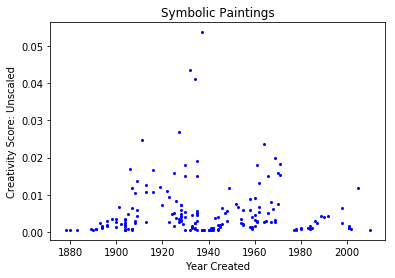

In [107]:
plt.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
plt.title("Symbolic Paintings")
plt.xlabel("Year Created")
plt.ylabel("Creativity Score: Unscaled")
plt.show()

### Finding the Most Creative Symbolic Painting

The code below with 'idxMax' will return the index of the max Creativity Score. This will show us which painting was the most creative. Then we will look for the 3 closest values in the Balanced array of creativity scores. This should show us what this painting is most similar to. However, none are present in this Balancing array. This means that none are similar to this in any way. 


In [108]:
idxMax = symb_paintDF.index.get_loc(symb_paintDF['Creativity Score'].idxmax(axis=1))
print(idxMax)
threeClosest = heapq.nlargest(3, zip(imgBalAr[idxMax], [i for i in range(len(imgBalAr[idxMax]))]))
print(threeClosest)


95
[(0.0, 181), (0.0, 180), (0.0, 179)]


So what I must do instead is find the 3 closest by transposing the array, and looking at it like that. The code below will demonstrate this. 


In [109]:
transBalAr = np.transpose(imgBalAr)
threeClosest = heapq.nlargest(4, zip(transBalAr[idxMax], [i for i in range(len(transBalAr[idxMax]))]))
print(threeClosest)


[(0.8762541806020067, 91), (0.568561872909699, 89), (0.15719063545150502, 93), (0.14715719063545152, 92)]


We see that painting at index 91, 89 and 93 are the most similar to painting at index 95. If we look further into what these paintings are, we get the following information. It looks as though my code is rewarding the paintings that have a high probability of incoming edges being chosen in the markov walk. 

In [110]:
print("This is painting at index 180: \n", symb_paintDF.iloc[idxMax], "\n")

print("Here are the paintings that are most similar: ")

print("This is painting at index 179: \n", symb_paintDF.iloc[threeClosest[0][1]])
print("This is painting at index 175: \n", symb_paintDF.iloc[threeClosest[1][1]])
print("This is painting at index 177: \n", symb_paintDF.iloc[threeClosest[2][1]])


This is painting at index 180: 
 artist              d3d2bb71e57d6bc4231e1370ed544649
title                                      Ecce Homo
style                                     Surrealism
genre                              symbolic painting
year                                            1937
Creativity Score                           0.0536775
Name: 11382.jpg, dtype: object 

Here are the paintings that are most similar: 
This is painting at index 179: 
 artist              3937af6d364e2f24d1cce16fe3916536
title                      Composition on a seashore
style                                     Surrealism
genre                              symbolic painting
year                                            1935
Creativity Score                           0.0151784
Name: 15990.jpg, dtype: object
This is painting at index 175: 
 artist              3937af6d364e2f24d1cce16fe3916536
title                                          Rape 
style                                     Surrea

Now that I have the name of these paintings I can easily display them along with the graph in a bit of an annotation.\

### Displaying Output with Images

In [111]:
def addImgPlt(info, x, y):
    # For the painting annotation
    arr_img = plt.imread("train_1/" + info.name)

    imagebox = OffsetImage(arr_img, zoom=0.05)
    imagebox.image.axes = ax

    xy = (info['year'], info['Creativity Score'])

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(x, y),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.5,
                        arrowprops=dict(
                            arrowstyle="->",
                            )
                        )
#     connectionstyle="angle,angleA=0,angleB=90,rad=3"
    ax.add_artist(ab)
    

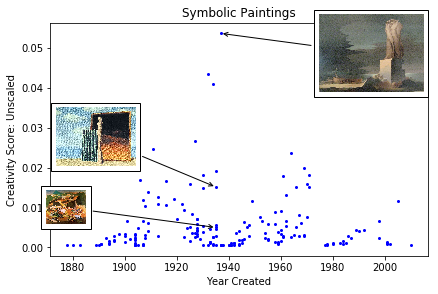

In [113]:
# plt.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
fig, ax = plt.subplots()

info = symb_paintDF.iloc[idxMax ]
addImgPlt(info, 150, -20)

info = symb_paintDF.iloc[threeClosest[0][1]]
addImgPlt(info, -120, 50)

# info = symb_paintDF.iloc[threeClosest[1][1]]
# addImgPlt(info, 175, 30)

info = symb_paintDF.iloc[threeClosest[2][1]]
addImgPlt(info, -150, 20)

ax.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
plt.title("Symbolic Paintings")
plt.xlabel("Year Created")
plt.ylabel("Creativity Score: Unscaled")

# For the painting 95 annotation
# arr_img = plt.imread("train_1/" + symb_paintDF.iloc[95].name)

# imagebox = OffsetImage(arr_img, zoom=0.05)
# imagebox.image.axes = ax

# xy = (symb_paintDF.iloc[95]['year'], symb_paintDF.iloc[95]['Creativity Score'])

# ab = AnnotationBbox(imagebox, xy,
#                     xybox=(150, -20),
#                     xycoords='data',
#                     boxcoords="offset points",
#                     pad=0.5,
#                     arrowprops=dict(
#                         arrowstyle="->",
#                         connectionstyle="angle,angleA=0,angleB=90,rad=3")
#                     )
# ax.add_artist(ab)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()


So we can see that these paintings have some similar features shared with the most creative paintings. This is also interesting to note that I had to transpose my array, which means that the most creative painting has nothing that is similar to it in the future, since no ratio was found between this painting and any other paintings. 

This may be caused by a number somewhere in my functions, however, I do believe that this could be seen as the most creative painting. 




### Lowest Creativity Score

Now that we have seen the highest creativity score, I wanted to look at the least creative artwork in this genre. Below I do similar code to finding the maximum value

In [114]:
idxMin = symb_paintDF.index.get_loc(symb_paintDF['Creativity Score'].idxmin(axis=1))

print(idxMin)
threeClosest = heapq.nlargest(3, zip(imgBalAr[idxMin], [i for i in range(len(imgBalAr[idxMin]))]))
print(threeClosest)


96
[(0.0, 181), (0.0, 180), (0.0, 179)]


In [115]:
transBalAr = np.transpose(imgBalAr)
threeClosest = heapq.nlargest(3, zip(transBalAr[idxMin], [i for i in range(len(transBalAr[idxMin]))]))
print(threeClosest)


[(0.0, 181), (0.0, 180), (0.0, 179)]


While this shows that there are no similar paintings to the least creative, I wanted to look at other entries from this. However, This painting has no connections to other paintings. And so in its normalized array, has all equal values, seen in the code below. This doesn't make sense for how the markov walk is supposed to work. But in the context of creativity does not. I'm not sure what is going on here. There should be some connections with paintings after it, but there is not. 

Interestingly enough, changing the Hessian threshold for the SURF classifier to 500 instead of 1000 actually bumps the 'Least Creative' painting into the most creative spot. I believe this has to do with the number of key points found in the painting. 

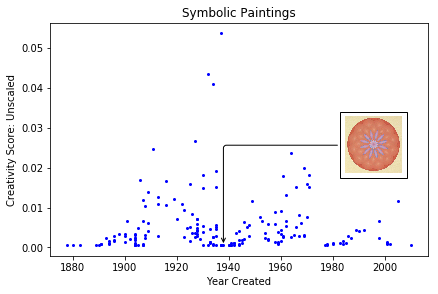

In [116]:
# plt.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
fig, ax = plt.subplots()

info = symb_paintDF.iloc[99]
# addImgPlt(info, 150, 100)

ax.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
plt.title("Symbolic Paintings")
plt.xlabel("Year Created")
plt.ylabel("Creativity Score: Unscaled")

# For the painting 95 annotation
arr_img = plt.imread("train_1/" + info.name)

imagebox = OffsetImage(arr_img, zoom=0.1)
imagebox.image.axes = ax

xy = (info['year'], info['Creativity Score'])

ab = AnnotationBbox(imagebox, xy,
                    xybox=(150, 100),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0.5,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )
ax.add_artist(ab)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()



### Changing the Hessian Threshold

This code is just showing how the threshold will affect my data. 


In [117]:
surf = cv2.xfeatures2d.SURF_create(300)

In [118]:
symb_paintDFHT = cpDF[cpDF['genre'] == 'symbolic painting']

In [119]:
imgCompArHT = compareImg(symb_paintDFHT, 10)
imgBalArHT = balanceW(imgCompArHT)
imgNormArHT = normalizeNP(imgBalArHT)

#MarkovChain
mc = markovChain(imgNormArHT)
mc.computePi('linear')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.4674602258913771
0.15749964089335564
0.7668373719843057
0.11869000986984148
0.9952522923805867
0.1207663392180972
0.23648404925748256
0.09159482758620689
0.10507260979745482
0.05936382536382537
0.06252528115671324
0.04195577566687073
0.10136181575433911
0.08451526350754307
0.16340979201677802
0.30187319560683157
0.7305033878071769
0.10248708418475537
0.06611570247933884
0.2600900006751909
0.7628410883769046
1.037639044922182
0.6632257574855625
0.5512394696186295
0.6867597594597493
0.23051247223802793
0.8830914898457722
0.16129032258064516
0.7736182228042666
0.006493506493506494
1.052325581395349
0.06976744186046512
0.11642229573896416
0.10893830870578498
0.12079970919665577
0.17735387851996337
0.09049320183508457
0.05491803278688524
0.03285714285714286
0.036753855177789986
0.013931362555215767
0.052667346245327894
0.01055594651653

In [122]:
symb_paintDFHT["Creativity Score"] = np.asarray(mc.pi)

/Users/reedmershon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
idxMaxHT = symb_paintDFHT.index.get_loc(symb_paintDFHT['Creativity Score'].idxmax(axis=1))
print(idxMaxHT)

#Not going to worry about checking the other way, as I know that there are no connections

transBalArHT = np.transpose(imgBalArHT)
threeClosestHT = heapq.nlargest(3, zip(transBalArHT[idxMaxHT], [i for i in range(len(transBalArHT[idxMaxHT]))]))
print(threeClosestHT)

99
[(2.2933333333333334, 95), (1.2533333333333334, 97), (1.1333333333333333, 96)]


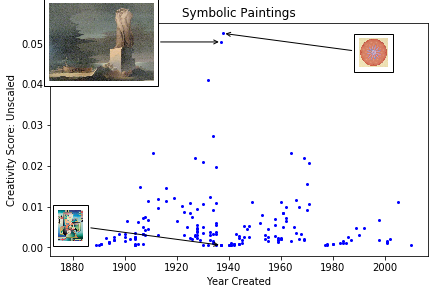

In [130]:
# plt.plot(symb_paintDF['year'], symb_paintDF['Creativity Score'], 'bo', markersize = 2)
fig, ax = plt.subplots()

info = symb_paintDFHT.iloc[idxMaxHT]
addImgPlt(info, 150, -20)

info = symb_paintDFHT.iloc[threeClosestHT[0][1]]
addImgPlt(info, -120, 0)

# info = symb_paintDF.iloc[threeClosest[1][1]]
# addImgPlt(info, 175, 30)

info = symb_paintDFHT.iloc[threeClosestHT[2][1]]
addImgPlt(info, -150, 20)

ax.plot(symb_paintDFHT['year'], symb_paintDFHT['Creativity Score'], 'bo', markersize = 2)
plt.title("Symbolic Paintings")
plt.xlabel("Year Created")
plt.ylabel("Creativity Score: Unscaled")

# For the painting 95 annotation
# arr_img = plt.imread("train_1/" + symb_paintDF.iloc[95].name)

# imagebox = OffsetImage(arr_img, zoom=0.05)
# imagebox.image.axes = ax

# xy = (symb_paintDF.iloc[95]['year'], symb_paintDF.iloc[95]['Creativity Score'])

# ab = AnnotationBbox(imagebox, xy,
#                     xybox=(150, -20),
#                     xycoords='data',
#                     boxcoords="offset points",
#                     pad=0.5,
#                     arrowprops=dict(
#                         arrowstyle="->",
#                         connectionstyle="angle,angleA=0,angleB=90,rad=3")
#                     )
# ax.add_artist(ab)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.show()

The above graph is very interesting to look at. It shows how the previously 'Least Creative' Painting is now the 'Most Creative' Painting. This is probably due to the number of keypoints/descriptors found with the threshold at 1000 compared to at 500. Below I will show the differences in the keypoints from the different thresholds

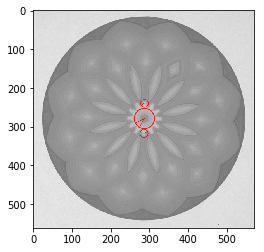

Keypoints:  4


In [134]:
#Threshold of 1000
img1 = cv2.imread('train_1/16895.jpg', 0)
surf = cv2.xfeatures2d.SURF_create(1000)

kp1, des1 = surf.detectAndCompute(img1, None)
img1_kp = cv2.drawKeypoints(img1, kp1, None, (255,0,0), 4)

plt.imshow(img1_kp), plt.show()
print("Keypoints: ", len(kp1))

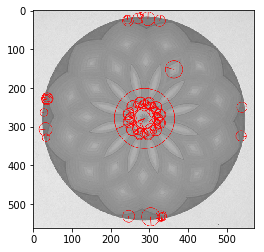

Keypoints:  75


In [135]:
#Threshold of 500
surf = cv2.xfeatures2d.SURF_create(500)

kp1, des1 = surf.detectAndCompute(img1, None)
img1_kp = cv2.drawKeypoints(img1, kp1, None, (255,0,0), 4)

plt.imshow(img1_kp), plt.show()
print("Keypoints: ", len(kp1))

Notice the 71 keypoint difference found. This is what would have pushed this image up towards the most creative score. 

### Proper Matching of the "Most Creative" and the Most Similar

In this section I will be graphing the 'most creative' work, and looking at the feature matches between the two. 

I have redefined this imgAnalysis function, so that I could plot the matches of the keypoints between two images. This is just so I have a reference for how the analysis is working. 

In [57]:
def imgAnalysis(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    
    surf = cv2.xfeatures2d.SURF_create(1000)

    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)
    
    print(len(kp2), len(des2))
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    print(len(good))

    # cv2.drawMatchesKnn expects list of lists as matches.
    img1_2 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
    plt.figure(figsize=(10, 20))
    plt.imshow(img1_2),plt.show()

299 299
47


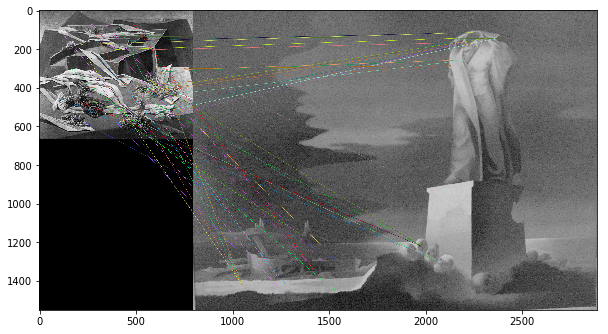

In [58]:
imgAnalysis('train_1/13397.jpg', 'train_1/11382.jpg')


299 299
262


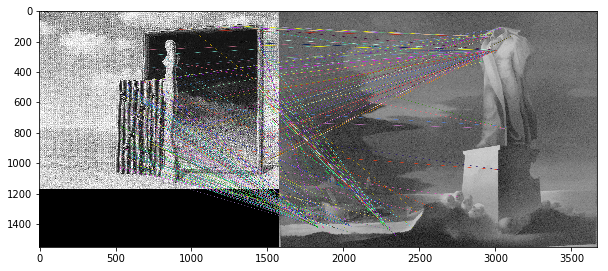

In [59]:
imgAnalysis('train_1/15990.jpg', 'train_1/11382.jpg')


In [36]:
symb_paintDF.iloc[99]


artist              65972a3cdf808987b805b2f77b84f767
title                                        Rosette
style                                     Concretism
genre                              symbolic painting
year                                            1938
Creativity Score                          0.00055914
Name: 16895.jpg, dtype: object

Below I just wanted to look at what was happening in my functions. There is clearly no common features found between painting at index 95 and that found at 99, which should be in its temporal neighbors and therefor have some connection. This shows that the temporal neighbors works, but there is no common point found.

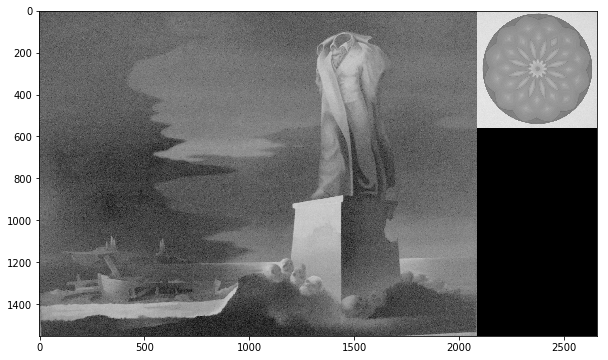

In [37]:
imgAnalysis('train_1/11382.jpg', 'train_1/16895.jpg')


In [137]:
symb_paintDF.iloc[95]


artist              d3d2bb71e57d6bc4231e1370ed544649
title                                      Ecce Homo
style                                     Surrealism
genre                              symbolic painting
year                                            1937
Creativity Score                           0.0536775
Name: 11382.jpg, dtype: object